# Crossentropy method

This notebook will teach you to solve reinforcement learning with crossentropy method.

In [1]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v2")
env.reset()
env.render()

[2017-01-29 15:43:14,909] Making new env: Taxi-v2


+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [2]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states,n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


In [4]:
policy = <your code here! Create an array to store action probabilities>

In [5]:
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)

# Play the game

Just like before, but we also record all states and actions we took.

In [7]:
def generate_session(t_max=10**4):
    """
    Play game until end or for t_max ticks.
    returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.
    
    s = env.reset()
    
    for t in range(t_max):
        
        a = <pick action from policy (at random with probabilities)>
        
        new_s,r,done,info = env.step(a)
        
        <record prev state, action and add up reward to states,actions and total_reward accordingly>
        
        s = new_s
        if done:
            break
    return states,actions,total_reward
        

In [8]:
s,a,r = generate_session()
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) is float

# Training loop
Generate sessions, select N best and fit to those.

In [9]:
n_samples = 250  #sample this many samples
percentile = 50  #take this percent of session with highest rewards
smoothing = 0.1  #add this thing to all counts for stability

for i in range(100):
    
    %time sessions = <generate n_samples sessions>]

    batch_states,batch_actions,batch_rewards = map(np.array,zip(*sessions))

    #batch_states: a list of lists of states in each session
    #batch_actions: a list of lists of actions in each session
    #batch_rewards: a list of floats - total rewards at each session
    
    threshold = <select percentile of your samples> 
    
    elite_states = <select states from sessions where rewards are above threshold> 
    elite_actions = <select actions from sessions where rewards are above threshold>
    
    elite_states, elite_actions = map(np.concatenate,[elite_states,elite_actions])
    #hint on task above: use np.percentile and numpy-style indexing
    
    #count actions from elite states
    elite_counts = np.zeros_like(policy)+smoothing
    
    <count all state-action occurences in elite_states and elite_actions>
    

    policy = <normalize over each state to get probabilities>
    
    
    print("mean reward = %.5f\tthreshold = %.1f"%(np.mean(batch_rewards),threshold))

CPU times: user 51.4 s, sys: 76 ms, total: 51.4 s
Wall time: 52.9 s
mean reward = -7925.98800	threshold = -5174.5
CPU times: user 13.6 s, sys: 28 ms, total: 13.6 s
Wall time: 14 s
mean reward = -2028.33200	threshold = -1316.5
CPU times: user 4.98 s, sys: 12 ms, total: 4.99 s
Wall time: 5.13 s
mean reward = -712.89200	threshold = -581.5
CPU times: user 2.49 s, sys: 4 ms, total: 2.49 s
Wall time: 2.52 s
mean reward = -332.32800	threshold = -289.5
CPU times: user 1.51 s, sys: 12 ms, total: 1.52 s
Wall time: 1.56 s
mean reward = -175.61600	threshold = -153.5
CPU times: user 1.08 s, sys: 0 ns, total: 1.08 s
Wall time: 1.12 s
mean reward = -108.96800	threshold = -90.5
CPU times: user 1.12 s, sys: 0 ns, total: 1.12 s
Wall time: 1.14 s
mean reward = -103.50000	threshold = -59.0
CPU times: user 868 ms, sys: 8 ms, total: 876 ms
Wall time: 885 ms
mean reward = -66.30000	threshold = -41.0
CPU times: user 952 ms, sys: 0 ns, total: 952 ms
Wall time: 981 ms
mean reward = -82.69200	threshold = -32.5
C

KeyboardInterrupt: 

# Approximate (deep) crossentropy method

In this section we will train a neural network policy for continuous action space game

[2017-01-29 15:35:01,960] Making new env: CartPole-v0


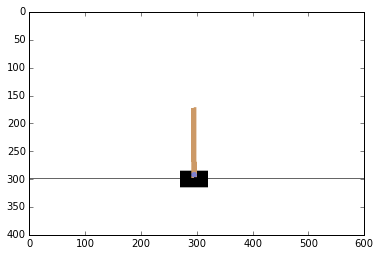

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")
env.reset()
n_actions = env.action_space.n

plt.imshow(env.render("rgb_array"))

In [6]:
#create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions,range(n_actions));


/home/jheuristic/anaconda2/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [13]:
def generate_session(t_max=1000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        
        #predict array of action probabilities
        probs = agent.predict_proba([s])[0] 
        
        a = <sample action with such probabilities>
        
        new_s,r,done,info = env.step(a)
        
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward+=r
        
        s = new_s
        if done: break
    return states,actions,total_reward
        

In [14]:
n_samples = 100
percentile = 70
smoothing = 0.01

for i in range(100):
    #generate new sessions
    sessions = [generate_session() for _ in range(n_samples)]

    batch_states,batch_actions,batch_rewards = map(np.array,zip(*sessions))
    #batch_states: a list of lists of states in each session
    #batch_actions: a list of lists of actions in each session
    #batch_rewards: a list of floats - total rewards at each session

    threshold = <select percentile of your samples>
    
    elite_states = <select states from sessions where rewards are above threshold>
    elite_actions = <select actions from sessions where rewards are above threshold>
    
    elite_states, elite_actions = map(np.concatenate,[elite_states,elite_actions])
    #elite_states: a list of states from top games
    #elite_actions: a list of actions from top games
    
    <fit agent to predict elite_actions(y) from elite_states(X)>


    print("mean reward = %.5f\tthreshold = %.1f"%(np.mean(batch_rewards),threshold))

threshold =  20.0 	mean elite reward =  27.2580645161
threshold =  19.0 	mean elite reward =  30.15625
threshold =  23.0 	mean elite reward =  29.2727272727
threshold =  26.0 	mean elite reward =  38.0
threshold =  29.0 	mean elite reward =  42.3333333333
threshold =  30.6 	mean elite reward =  49.4
threshold =  40.0 	mean elite reward =  53.6451612903
threshold =  40.6 	mean elite reward =  61.9666666667
threshold =  55.6 	mean elite reward =  82.6333333333
threshold =  54.3 	mean elite reward =  77.5333333333
threshold =  62.0 	mean elite reward =  86.5625
threshold =  68.0 	mean elite reward =  88.6774193548
threshold =  75.0 	mean elite reward =  105.870967742
threshold =  82.3 	mean elite reward =  107.133333333
threshold =  75.6 	mean elite reward =  113.733333333
threshold =  95.3 	mean elite reward =  135.933333333
threshold =  107.3 	mean elite reward =  138.766666667
threshold =  135.9 	mean elite reward =  180.9
threshold =  156.3 	mean elite reward =  186.966666667
threshol

KeyboardInterrupt: 

# Results

In [27]:
#finish recording
import gym.wrappers
env = gym.wrappers.Monitor(env,directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()
#unwrap 
env = env.env.env
#upload to gym
#gym.upload("./videos/",api_key="<your_api_key>") 

[2017-01-29 15:42:03,501] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-29 15:42:03,505] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-01-29 15:42:03,510] Starting new video recorder writing to /home/jheuristic/Documents/wouldbe_rl_course/week1/videos/openaigym.video.1.11230.video000000.mp4
[2017-01-29 15:42:09,909] Starting new video recorder writing to /home/jheuristic/Documents/wouldbe_rl_course/week1/videos/openaigym.video.1.11230.video000001.mp4
[2017-01-29 15:42:16,704] Starting new video recorder writing to /home/jheuristic/Documents/wouldbe_rl_course/week1/videos/openaigym.video.1.11230.video000008.mp4
[2017-01-29 15:42:23,466] Starting new video recorder writing to /home/jheuristic/Documents/wouldbe_rl_course/week1/videos/openaigym

In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Challenge

Now try to solve LunarLander-v2 or MountainCar-v0